<a href="https://colab.research.google.com/github/LeoMcBills/tensorFlowPrac/blob/main/kerasNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras  # Upgrades to keras 3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
import keras_nlp
import keras

# Use mixed precision to speed up all training in this guide
keras.mixed_precision.set_global_policy("mixed_float16")

# Data

In [4]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!# Remove unsupervised examples
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  15.1M      0  0:00:05  0:00:05 --:--:-- 16.2M


In [5]:
BATCH_SIZE = 16
imdb_train = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
)
imdb_test = keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=BATCH_SIZE,
)

# Inspect first review
# Format is (review text tensor, label tensor)
print(imdb_train.unbatch().take(1).get_single_element())

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
(<tf.Tensor: shape=(), dtype=string, numpy=b"Cameron Diaz is a woman who is married to a judge, played by Harvey Keitel, whose life is fine until an ex shows up and things get a little complicated.. While I was watching this movie there were several times i asked myself why I was doing so..because the movie is so ridiculous and blah and poorly scripted without any believability. Nor does the audience really car what happens..Even the lovely Cameron can't save this one on a scale of one to ten..2">, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


# Inference with a Pretrained Classifier

In [6]:
classifier = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased_sst2")
# Note: batched inputs expected so must wrap string in iterable
classifier.predict(["I love modular workflows in keras-nlp!"])

100%|██████████| 2.14k/2.14k [00:00<00:00, 1.39MB/s]
100%|██████████| 226k/226k [00:00<00:00, 1.03MB/s]
100%|██████████| 16.8M/16.8M [00:00<00:00, 22.3MB/s]
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[-1.539,  1.543]], dtype=float16)

# The output below is [loss, accuracy]

In [7]:
classifier.evaluate(imdb_test)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.4668 - sparse_categorical_accuracy: 0.7818


[0.4628835916519165, 0.783519983291626]

# Finetuning a pretrained BERT model

In [8]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=2,
)
classifier.fit(
    imdb_train,
    validation_data=imdb_test,
    epochs=1,
)

100%|██████████| 507/507 [00:00<00:00, 349kB/s]
100%|██████████| 16.8M/16.8M [00:01<00:00, 17.3MB/s]
100%|██████████| 547/547 [00:00<00:00, 303kB/s]
100%|██████████| 226k/226k [00:00<00:00, 1.01MB/s]


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 101s 39ms/step - loss: 0.5169 - sparse_categorical_accuracy: 0.7313 - val_loss: 0.3093 - val_sparse_categorical_accuracy: 0.8678


# Fine-tuning using user controlled-preprocessing

In [10]:
import tensorflow as tf

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_tiny_en_uncased",
    sequence_length=512,
)

# Apply the preprocessor to every sample of train and test data using `map()`.
# [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data/AUTOTUNE) and `prefetch()` are options to tune performance, see
# https://www.tensorflow.org/guide/data_performance for details.

# Note: only call `cache()` if you training data fits in CPU memory!

imdb_train_cached = (
    imdb_train.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

imdb_test_cached = (
    imdb_test.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased", preprocessor=None, num_classes=2
)

classifier.fit(
    imdb_train_cached,
    validation_data=imdb_test_cached,
    epochs=3,
)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step - loss: 0.5123 - sparse_categorical_accuracy: 0.7338 - val_loss: 0.3360 - val_sparse_categorical_accuracy: 0.8544
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 85s 54ms/step - loss: 0.2883 - sparse_categorical_accuracy: 0.8837 - val_loss: 0.3017 - val_sparse_categorical_accuracy: 0.8745
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - loss: 0.2053 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.3324 - val_sparse_categorical_accuracy: 0.8700


# Custom preprocessing

In [11]:
tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_tiny_en_uncased")
tokenizer(["I love modular workflows!", "Libraries over frameworks!"])

# Write your own packer or use one of our `Layers`
packer = keras_nlp.layers.MultiSegmentPacker(
    start_value=tokenizer.cls_token_id,
    end_value=tokenizer.sep_token_id,
    # Note: This cannot be longer than the preset's `sequence_length`, and there
    # is no check for a custom preprocessor!
    sequence_length=64,
)


# This function that takes a text sample `x` and its
# corresponding label `y` as input and converts the
# text into a format suitable for input into a BERT model.
def preprocessor(x, y):
    token_ids, segment_ids = packer(tokenizer(x))
    x = {
        "token_ids": token_ids,
        "segment_ids": segment_ids,
        "padding_mask": token_ids != 0,
    }
    return x, y


imdb_train_preprocessed = imdb_train.map(preprocessor, tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)
imdb_test_preprocessed = imdb_test.map(preprocessor, tf.data.AUTOTUNE).prefetch(
    tf.data.AUTOTUNE
)

# Preprocessed example
print(imdb_train_preprocessed.unbatch().take(1).get_single_element())

({'token_ids': <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([  101,  7929,  1045,  2018,  3020,  8069,  2005,  2023,  2482,
       15460, 21159,  3185,  3432,  2138,  2009,  2790,  2066,  1996,
       25815,  2020,  2893,  2488,  2004,  2027,  2234,  2041,  1012,
        1045,  2106,  2066,  2482, 15460, 21159,  1016,  2488,  2084,
        1015,  1012,  1045,  6618,  2092,  2023,  2028,  2003, 10947,
        2061,  2009,  2442,  2022,  2488,  2157,  1029,  2092,  1012,
        1012,  1012,  1045,  2855,  4342,  1045,  2001,  3308,  1012,
         102], dtype=int32)>, 'segment_ids': <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)>, 'padding_mask': <tf.Tensor: shape=(64,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  T

# Finetuning with a custom model

In [12]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_tiny_en_uncased")
backbone = keras_nlp.models.BertBackbone.from_preset("bert_tiny_en_uncased")

imdb_train_preprocessed = (
    imdb_train.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)
imdb_test_preprocessed = (
    imdb_test.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

backbone.trainable = False
inputs = backbone.input
sequence = backbone(inputs)["sequence_output"]
for _ in range(2):
    sequence = keras_nlp.layers.TransformerEncoder(
        num_heads=2,
        intermediate_dim=512,
        dropout=0.1,
    )(sequence)
# Use [CLS] token output to classify
outputs = keras.layers.Dense(2)(sequence[:, backbone.cls_token_index, :])

model = keras.Model(inputs, outputs)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
model.summary()
model.fit(
    imdb_train_preprocessed,
    validation_data=imdb_test_preprocessed,
    epochs=3,
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_backbone             │ [(None, 128), (None,   │      4,385,920 │ padding_mask[0][0],    │
│ (BertBackbone)            │ None, 128)]            │                │ segment_ids[0][0],     │
│                           │                        │                │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 128)      │        198,272 │ bert_backbone[0][1]    │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 128)      │        198,272 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 128)            │              0 │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │            258 │ get_item_5[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,782,722 (18.24 MB)

 Trainable params: 396,802 (1.51 MB)

 Non-trainable params: 4,385,920 (16.73 MB)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 119s 51ms/step - loss: 0.6479 - sparse_categorical_accuracy: 0.6386 - val_loss: 0.5296 - val_sparse_categorical_accuracy: 0.7371
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 20ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.4414 - val_sparse_categorical_accuracy: 0.7946
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 0.4516 - sparse_categorical_accuracy: 0.7881 - val_loss: 0.3986 - val_sparse_categorical_accuracy: 0.8202


# Build and train transformer from scratch

### Train custom vocabulary from IMDB data

In [13]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    imdb_train.map(lambda x, y: x),
    vocabulary_size=20_000,
    lowercase=True,
    strip_accents=True,
    reserved_tokens=["[PAD]", "[START]", "[END]", "[MASK]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    strip_accents=True,
    oov_token="[UNK]",
)

# Process data with a custom tokenizer

In [15]:
packer = keras_nlp.layers.StartEndPacker(
    start_value=tokenizer.token_to_id("[START]"),
    end_value=tokenizer.token_to_id("[END]"),
    pad_value=tokenizer.token_to_id("[PAD]"),
    sequence_length=512,
)

def preprocess(x, y):
  token_ids = packer(tokenizer(x))
  return token_ids, y

imdb_preproc_train_ds = imdb_train.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

imdb_preproc_val_ds = imdb_test.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print(imdb_preproc_train_ds.unbatch().take(1).get_single_element())

(<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([    1,   420, 10016,    18,   100,    43,   257,   111,   771,
         112,    18,    96,   248,   117,  1574,    16,    96,   112,
         100,  1574,   174,    16,   111,    51,   181,    11,    62,
         214,   179,    99,  1774,    96,   204,    18,    51,   171,
         231,   175,    96,   204,   397,   114,    18,   104,   100,
          43,   110,   109,   141,  1007,  1065,  3032,    18,  1486,
         395,  3594,   107,    43,   662,    17,   217,    16,   154,
         161,   311,   247,   693,   103, 15737,   305,  3930,   154,
          51,   521,    18,    32,   101,    19,    34,    32,   101,
          19,    34,   219,   161,   119, 11182,  9996,   490,    43,
        1907,  1839,   417,   868, 12771,  8871,   400,   977,  4128,
         133,   233,   130,   105,    18,   132,   196,   100,  1127,
          18,   131,   100,    43,   226,   210,   145,  4091,    43,
        9314,   275,   132,  4902,    18,  

# Design a tiny transformer

In [16]:
token_id_input = keras.Input(
    shape=(None,),
    dtype="int32",
    name="token_ids",
)

outputs = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=len(vocab),
    sequence_length=packer.sequence_length,
    embedding_dim=64,
)(token_id_input)

outputs = keras_nlp.layers.TransformerEncoder(
    num_heads=2,
    intermediate_dim=128,
    dropout=0.1,
)(outputs)

# Use "[START]" token to classify
outputs = keras.layers.Dense(2)(outputs[:, 0, :])
model = keras.Model(
    inputs=token_id_input,
    outputs=outputs,
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 64)            │       1,259,648 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_2                │ (None, None, 64)            │          33,472 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_6 (GetItem)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,293,250 (4.93 MB)

 Trainable params: 1,293,250 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

# Train transformer

In [17]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
model.fit(
    imdb_preproc_train_ds,
    validation_data=imdb_preproc_val_ds,
    epochs=3,
)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 61s 27ms/step - loss: 0.7236 - sparse_categorical_accuracy: 0.5338 - val_loss: 0.5344 - val_sparse_categorical_accuracy: 0.7642
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.4639 - sparse_categorical_accuracy: 0.7821 - val_loss: 0.3915 - val_sparse_categorical_accuracy: 0.8229
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.3190 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.3259 - val_sparse_categorical_accuracy: 0.8644


# Transfromer

In [22]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_nlp
import keras

# Use mixed precision to speed up all training in this guide
keras.mixed_precision.set_global_policy("mixed_float16")

# Data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!# Remove unsupervised examples
!rm -r aclImdb/train/unsup

# Preprocessing
BATCH_SIZE = 16
imdb_train = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=BATCH_SIZE,
)
imdb_test = keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=BATCH_SIZE,
)

# Inspect first review
# Format is (review text tensor, label tensor)
print(imdb_train.unbatch().take(1).get_single_element())

# train custom vocabulary from IMBD data

vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    imdb_train.map(lambda x, y: x),
    vocabulary_size=20000,
    lowercase=True,
    strip_accents=True,
    reserved_tokens=["[PAD]", "[START]", "[END]", "[MASK]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    strip_accents=True,
    oov_token="[UNK]",
)

# Process data using a custom customer
packer = keras_nlp.layers.StartEndPacker(
    start_value=tokenizer.token_to_id("[START]"),
    end_value=tokenizer.token_to_id("[END]"),
    pad_value=tokenizer.token_to_id("[PAD]"),
    sequence_length=512,
)

def preprocess(x, y):
  token_ids = packer(tokenizer(x))
  return token_ids, y

imdb_preproc_train_ds = imdb_train.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

imdb_preproc_val_ds = imdb_test.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

print(imdb_preproc_train_ds.unbatch().take(1).get_single_element())

# Design of a tiny transformer
token_id_input = keras.Input(
    shape=(None,),
    dtype="int32",
    name="token_ids",
)

outputs = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=len(vocab),
    sequence_length=packer.sequence_length,
    embedding_dim=64,
)(token_id_input)

outputs = keras_nlp.layers.TransformerEncoder(
    num_heads=2,
    intermediate_dim=128,
    dropout=0.1,
)(outputs)

# Use "[START]" token to classify
outputs = keras.layers.Dense(2)(outputs[:, 0, :])
model = keras.Model(
    inputs=token_id_input,
    outputs=outputs,
)

model.summary()

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.AdamW(5e-5),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    jit_compile=True,
)
model.fit(
    imdb_preproc_train_ds,
    validation_data=imdb_preproc_val_ds,
    epochs=3,
)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  41.8M      0  0:00:01  0:00:01 --:--:-- 41.8M
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
(<tf.Tensor: shape=(), dtype=string, numpy=b"There can be no questions of spoilers for this movie, the director beat us all too and spoiled this movie in oh so many ways.<br /><br />A blatant rip-off of stuff like Critters and Gremlins, this movie fails on so many levels to recapture the humour and horror of those better made films. It ends up a sleazy waste of time, where bad actors deliver bad dialogue in front of an idiot director, who occasionally tosses stuffed toys at them. They wrestle with said toys in much the same manner as old Tarzan films used to use rubber crocodiles, shaking them whilst screaming and trying their best to make it look slightly threatening. I

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, None, 64)            │       1,259,648 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_3                │ (None, None, 64)            │          33,472 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_7 (GetItem)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,293,250 (4.93 MB)

 Trainable params: 1,293,250 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 0.7241 - sparse_categorical_accuracy: 0.5238 - val_loss: 0.5433 - val_sparse_categorical_accuracy: 0.7534
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.4658 - sparse_categorical_accuracy: 0.7817 - val_loss: 0.3932 - val_sparse_categorical_accuracy: 0.8198
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.3183 - val_sparse_categorical_accuracy: 0.8639


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  33.0M      0  0:00:02  0:00:02 --:--:-- 33.0M


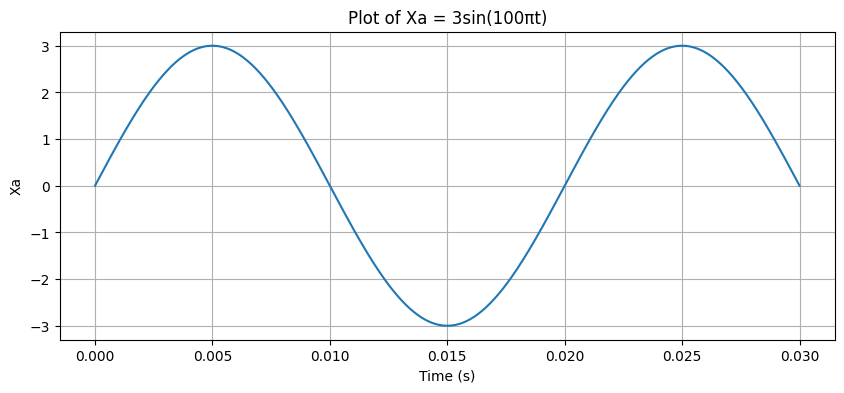

In [4]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, 0.03, 500)  # time vector from 0 to 30ms
Xa = 3 * np.sin(100 * np.pi * t)  # the signal

plt.figure(figsize=(10, 4))
plt.plot(t, Xa)
plt.title('Plot of Xa = 3sin(100πt)')
plt.xlabel('Time (s)')
plt.ylabel('Xa')
plt.grid(True)
plt.show()

<ipython-input-5-70f0f97067ea>:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(n, xn, 'r', markerfmt='ro', use_line_collection=True)


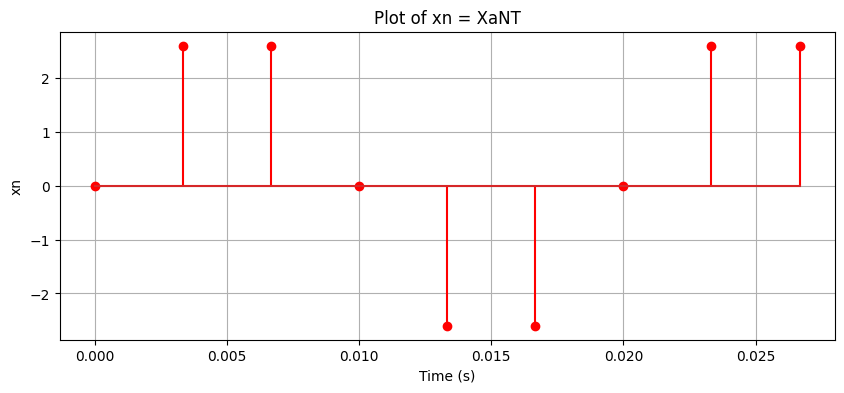

In [5]:
Fs = 300  # sampling rate
T = 1 / Fs  # sampling period
n = np.arange(0, 0.03, T)  # sample index vector from 0 to 30ms
xn = 3 * np.sin(100 * np.pi * n)  # the discrete-time signal

plt.figure(figsize=(10, 4))
plt.stem(n, xn, 'r', markerfmt='ro', use_line_collection=True)
plt.title('Plot of xn = XaNT')
plt.xlabel('Time (s)')
plt.ylabel('xn')
plt.grid(True)
plt.show()

<ipython-input-6-6db40cfeff40>:19: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(n, xn, 'r', markerfmt='ro', use_line_collection=True, label='xn')


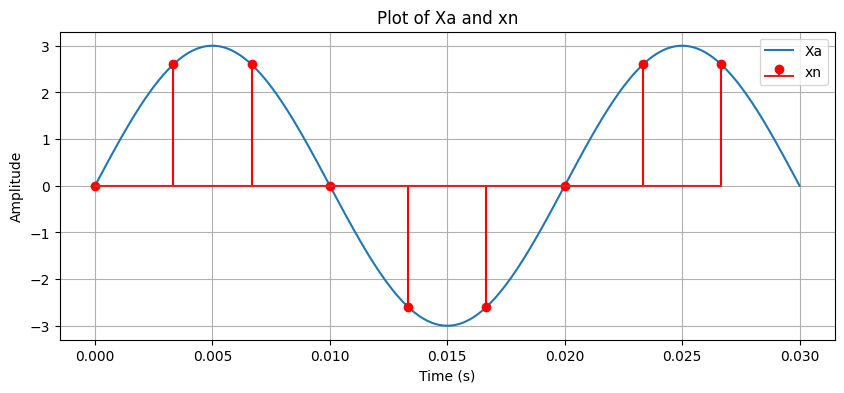

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time vector for Xa
t = np.linspace(0, 0.03, 500)  # time vector from 0 to 30ms
Xa = 3 * np.sin(100 * np.pi * t)  # the signal

# Define the sampling rate and calculate xn
Fs = 300  # sampling rate
Ts = 1 / Fs  # sampling period
n = np.arange(0, 0.03, Ts)  # sample index vector from 0 to 30ms
xn = 3 * np.sin(100 * np.pi * n)  # the discrete-time signal

# Plot Xa
plt.figure(figsize=(10, 4))
plt.plot(t, Xa, label='Xa')

# Plot xn
plt.stem(n, xn, 'r', markerfmt='ro', use_line_collection=True, label='xn')

plt.title('Plot of Xa and xn')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()